# Case Study 2: Machine learning model for UCI-SECOM data set
- dataset: https://www.kaggle.com/code/kirshoff/secom-dataset-analysis
- SECOM 데이터 세트에는 웨이퍼 제조를 위한 생산 라인에서 시작된 1567개의 예가 포함되어 있다.
  - 각 예는 590개의 센서 측정값 벡터와 통과/실패 테스트 식별이다.
  - 1567개의 예 중에서 양성으로 표시된 실패(Fail) 사례는 104개에 불과한 반면(1로 코딩됨), 훨씬 더 많은 수의 예가 테스트를 통과(Pass)하고 음성으로 표시됨. (-1로 코딩됨).
  - 통과 및 실패 사례 간의 불균형(Imbalance)과 수백 개의 센서에서 얻은 방대한 양의 측정 데이터로 인해 이 데이터 세트를 정확하게 분석하기 어렵다.
- Reference at:
  - https://www.kaggle.com/code/johnreyfaciolan/secom-feature-selection
  - https://www.kaggle.com/code/aliadel21/semi-conductors-defects-advanced

- Steps:
  - download the dataset (https://www.kaggle.com/code/kirshoff/secom-dataset-analysis)
  - data read and library import
  - feature engineering
    - remove features of too many missing values
    - remove duplicated features (if any)
    - remove features of zero-variance
  - data splitting (train and test)
  - Use Pipeline()
    - imputation for missing values
    - scaling
    - dimension reduction (feature selection, dimension reduction)
    - make it balanced (SMOTE, BorderlineSMOTE, ADASYN)
    - classification (fit and prediction)

## Data read

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import OneClassSVM

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

In [2]:
df = pd.read_csv("uci-secom.csv.zip")

In [3]:
print(df.shape)
df.head(3)

(1567, 592)


,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1


In [4]:
# 결함 레이블 분포 확인
print(df['Pass/Fail'].value_counts())

Pass/Fail
-1    1463
 1     104
Name: count, dtype: int64


In [5]:
df.shape   # 1567 samples, 592 features

(1567, 592)

<Axes: >

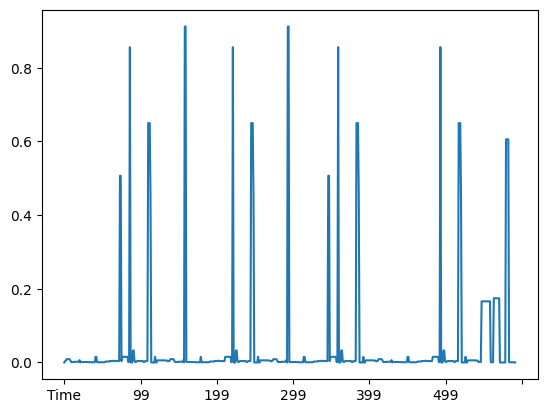

In [6]:
(df.isna().sum(0)/df.shape[0]).plot()

## Remove features that have too many missing values

In [7]:
threshold = 0.15
missing_percentages = df.isnull().mean(axis=0)
features_to_drop = missing_percentages[missing_percentages > threshold].index
df_cleaned = df.drop(columns=features_to_drop)

In [8]:
print(df_cleaned.shape)

(1567, 540)


- 52 columns are removed

In [9]:
df_cleaned.isna().mean(0).sort_values(ascending=False)

,0
224,0.032546
363,0.032546
362,0.032546
89,0.032546
497,0.032546
...,...
361,0.000000
360,0.000000
359,0.000000
291,0.000000


<Axes: >

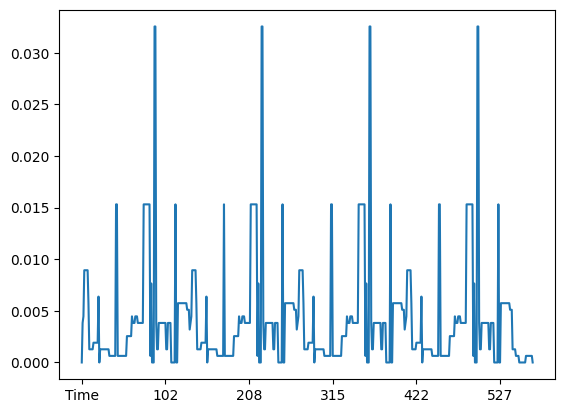

In [10]:
df_cleaned.isna().mean(axis=0).plot()

- 분산이 0인 기능은 모든 관찰에 대해 정확히 동일한 값을 가지므로 전혀 정보가 없다. 따라서 이를 확인해 본다.

In [11]:
pd.concat([df_cleaned.head(3), df_cleaned.tail(3)])

,Time,0,1,2,3,4,5,6,7,8,...,577,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,14.9509,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
1564,2008-10-17 05:26:00,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,NaN,...,17.7267,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231,-1
1565,2008-10-17 06:01:00,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.4622,...,19.2104,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941,-1
1566,2008-10-17 06:07:00,2944.92,2450.76,2195.4444,2914.1792,1.5978,100.0,85.1011,0.1235,NaN,...,22.9183,0.4987,0.0181,0.0040,3.6275,0.0117,0.0162,0.0045,137.7844,-1


In [12]:
## The Time column does not have sinificant meaning in this dataset.
df_cleaned = df_cleaned.drop('Time', axis=1)

In [13]:
df_cleaned.var().sort_values()

,0
191,0.000000e+00
189,0.000000e+00
190,0.000000e+00
192,0.000000e+00
193,0.000000e+00
...,...
296,3.901065e+06
24,8.425610e+06
297,1.041304e+07
161,1.797120e+07


In [14]:
df_cleaned.iloc[:,5]   # variance 0

,5
0,100.0
1,100.0
2,100.0
3,100.0
4,100.0
...,...
1562,100.0
1563,100.0
1564,100.0
1565,100.0


In [15]:
# 1. Calculate the variance for each column
variances = df_cleaned.var()

# 2. Identify columns with zero variance
zero_variance_columns = variances[variances == 0].index
print(zero_variance_columns)

# 3. Remove columns with zero variance
df_cleaned_no_zero_variance = df_cleaned.drop(columns=zero_variance_columns)
print("number of columns that has Zero variance and removed: ",len(zero_variance_columns))

Index(['5', '13', '42', '49', '52', '69', '97', '141', '149', '178',
       ...
       '529', '530', '531', '532', '533', '534', '535', '536', '537', '538'],
      dtype='object', length=116)
number of columns that has Zero variance and removed:  116


In [16]:
len(df_cleaned_no_zero_variance.columns) # we still have 424 feature

423

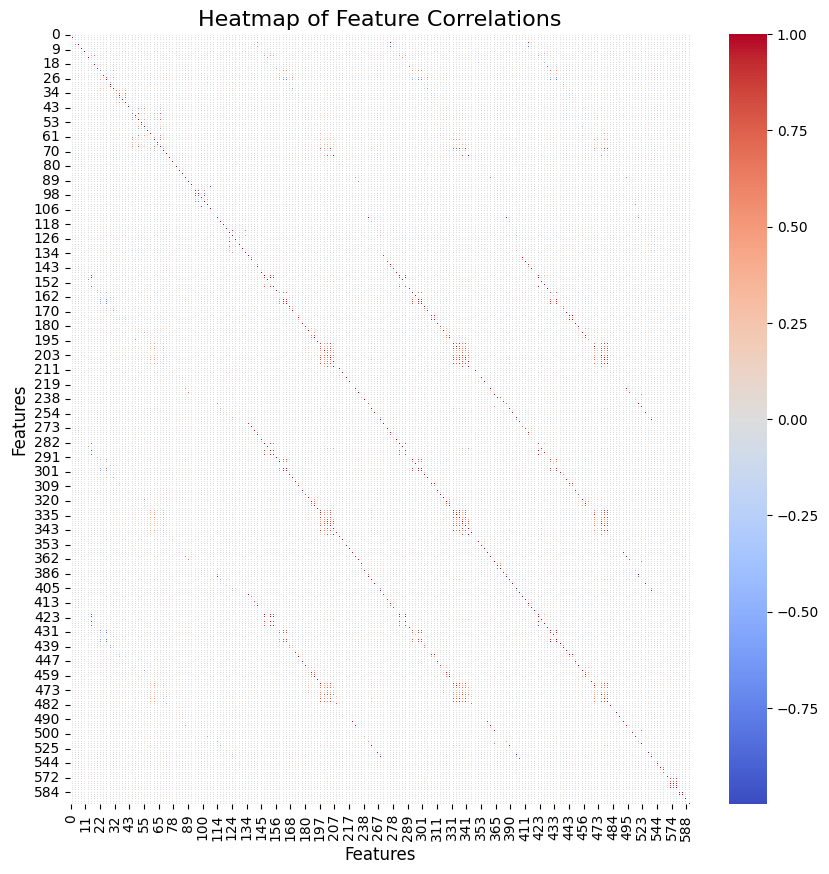

In [17]:
# Compute the correlation matrix
correlation_matrix = df_cleaned_no_zero_variance.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 10))  # Adjust size as needed

# Draw the heatmap
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.1f', linewidths=0.5)

# Add titles and labels
plt.title('Heatmap of Feature Correlations', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Show the plot
plt.show()

- 타겟 피처와 상관관계가 낮은 피처는 타겟 예측에 도움이 안되므로 제거한다 (corr < 0.05)

In [18]:
correlations = df_cleaned_no_zero_variance.corr()['Pass/Fail'].abs()  # Get absolute values of correlation

# Set the threshold for correlation
threshold = 0.05

# Identify features to keep (correlation with target >= threshold)
features_to_keep = correlations[correlations >= threshold].index
features_to_keep

Index(['14', '21', '22', '26', '28', '32', '33', '38', '40', '56', '58', '59',
       '63', '64', '65', '68', '70', '76', '79', '90', '95', '100', '103',
       '114', '121', '122', '123', '124', '125', '126', '127', '129', '130',
       '133', '159', '160', '163', '164', '165', '166', '180', '183', '196',
       '197', '199', '200', '205', '210', '249', '280', '294', '295', '298',
       '299', '300', '316', '319', '337', '348', '365', '387', '430', '431',
       '434', '435', '436', '437', '452', '455', '460', '468', '469', '471',
       '477', '510', '511', '542', '543', '573', '575', 'Pass/Fail'],
      dtype='object')

In [19]:
df_cleaned_filtered = df_cleaned_no_zero_variance[features_to_keep]

In [20]:
df_cleaned_filtered.head(3)

,14,21,22,26,28,32,33,38,40,56,...,469,471,477,510,511,542,543,573,575,Pass/Fail
0,7.9558,-5419.00,2916.50,1.7730,64.2333,83.3971,9.5126,86.9555,61.29,0.9317,...,5.7277,9.7752,5.8142,64.6707,0.0000,0.1096,0.0078,0.3157,0.1026,-1
1,10.1548,-5441.50,2604.25,2.0143,68.4222,84.9052,9.7997,87.5241,78.25,0.9324,...,5.5652,10.2211,5.8042,141.4365,0.0000,0.1096,0.0078,0.2653,0.0772,-1
2,9.5157,-5447.75,2701.75,2.0295,67.1333,84.7569,8.6590,84.7327,14.37,0.9139,...,5.4178,8.3977,9.1221,240.7767,244.2748,0.1096,0.0078,0.1882,0.0640,1


In [21]:
len(df_cleaned_no_zero_variance.columns) - len(df_cleaned_filtered.columns)

342

- Note : We have 342 feature with low correlation with the target¶

In [22]:
df_cleaned_filtered.shape

(1567, 81)

- now we have 81 features.

## Splitting the data into features (X) and target (y)

In [23]:
df_cleaned_filtered.head(3)

,14,21,22,26,28,32,33,38,40,56,...,469,471,477,510,511,542,543,573,575,Pass/Fail
0,7.9558,-5419.00,2916.50,1.7730,64.2333,83.3971,9.5126,86.9555,61.29,0.9317,...,5.7277,9.7752,5.8142,64.6707,0.0000,0.1096,0.0078,0.3157,0.1026,-1
1,10.1548,-5441.50,2604.25,2.0143,68.4222,84.9052,9.7997,87.5241,78.25,0.9324,...,5.5652,10.2211,5.8042,141.4365,0.0000,0.1096,0.0078,0.2653,0.0772,-1
2,9.5157,-5447.75,2701.75,2.0295,67.1333,84.7569,8.6590,84.7327,14.37,0.9139,...,5.4178,8.3977,9.1221,240.7767,244.2748,0.1096,0.0078,0.1882,0.0640,1


In [24]:
X = df_cleaned_filtered.iloc[:, :-1]
y = df_cleaned_filtered.iloc[:, -1]

In [25]:
X.head(3)

,14,21,22,26,28,32,33,38,40,56,...,468,469,471,477,510,511,542,543,573,575
0,7.9558,-5419.00,2916.50,1.7730,64.2333,83.3971,9.5126,86.9555,61.29,0.9317,...,311.6377,5.7277,9.7752,5.8142,64.6707,0.0000,0.1096,0.0078,0.3157,0.1026
1,10.1548,-5441.50,2604.25,2.0143,68.4222,84.9052,9.7997,87.5241,78.25,0.9324,...,463.2883,5.5652,10.2211,5.8042,141.4365,0.0000,0.1096,0.0078,0.2653,0.0772
2,9.5157,-5447.75,2701.75,2.0295,67.1333,84.7569,8.6590,84.7327,14.37,0.9139,...,21.3645,5.4178,8.3977,9.1221,240.7767,244.2748,0.1096,0.0078,0.1882,0.0640


In [26]:
y.head(3)  # -1: Pass, 1: Fail

,Pass/Fail
0,-1
1,-1
2,1


In [27]:
X.shape, y.shape

((1567, 80), (1567,))

In [28]:
y.value_counts()

,count
Pass/Fail,
-1,1463
1,104


In [29]:
X.isnull().sum().sum(), y.isnull().sum()  # we have many missing values

(453, 0)

## Strategies
- unbalanced data
- balanced data
- balanced data with dimension reduction (PCA)
- balanced data with feature selection

In [30]:
from sklearn.model_selection import train_test_split

from sklearn import set_config
set_config(transform_output = "pandas")  # to make output of transformations returned as pandas dataframes
                                         # useful when working with pipelines and chaining

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=17,
    stratify=y
)

In [31]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1253, 80) (314, 80) (1253,) (314,)


In [32]:
X_train.duplicated().sum()   # no duplicated rows

0

- sklearn.pipeline.Pipeline()
  - This is the standard Pipeline provided by scikit-learn. It is used to streamline a sequence of data preprocessing steps (like scaling, encoding, or imputing missing values) followed by model training.
  - It assumes that all transformers return a dataset of the same size as the input. (Sampling is not supported)
- imblearn.pipeline.Pipeline()
  - an extension of the scikit-learn Pipeline, provided by the imbalanced-learn library. It is specifically designed to handle cases where you need to apply resampling techniques (such as SMOTE, ADASYN, or undersampling methods) within the pipeline.
  - It correctly handles resampling during the training process while ensuring the integrity of the validation or test data.
  - The fit_resample method is applied instead of just fit, which allows the resampling technique to generate synthetic samples and alter the dataset size as needed during the training phase.

In [33]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score

- The dataset was too high-dimensional. It is difficult to check the individual univariate descriptive statistics.

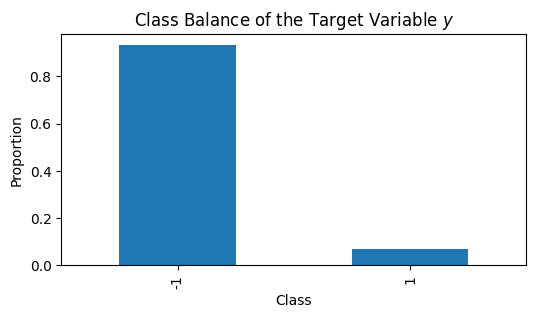

In [34]:
y_train.value_counts(normalize=True).plot(kind="bar", figsize=(6,3))
plt.title("Class Balance of the Target Variable $y$");
plt.xlabel("Class")
plt.ylabel("Proportion")
plt.show()

- It can be clearly seen on the above plot that the dataset has a serious issue of class imbalance. more than 90% of the data belong to -1 class.

## Strategy 1: Unbalanced

In [35]:
from sklearn.pipeline import Pipeline

pipeline1 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    # ('classifier', RandomForestClassifier(random_state=42))
    ('classifier', LogisticRegression(max_iter=150))
])

pipeline1.fit(X_train, y_train)
y_pred = pipeline1.predict(X_test)
print("Accuracy Score: {}".format(pipeline1.score(X_test, y_test)))
print("Balanced Accuracy: {}".format(balanced_accuracy_score(y_test, y_pred)))
print(confusion_matrix(y_test, y_pred))

Accuracy Score: 0.9203821656050956
Balanced Accuracy: 0.5594831789371039
[[286   7]
 [ 18   3]]


## Strategy 2: Balanced

In [36]:
# without Pipeline

from imblearn.over_sampling import SMOTE

X_train_ = X_train.copy()
X_test_ = X_test.copy()

imputer = SimpleImputer(strategy='mean')
X_train_ = imputer.fit_transform(X_train_)

scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train_)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_, y_train)
print("After SMOTE resampling: {}".format(y_train_balanced.value_counts()))

# clf = RandomForestClassifier(random_state=17)
clf = LogisticRegression(max_iter=150)
clf.fit(X_train_balanced, y_train_balanced)

# testing

X_test_ = imputer.transform(X_test_)
X_test_ = scaler.transform(X_test_)

y_pred = clf.predict(X_test_)
print("Accuracy Score: {}".format(clf.score(X_test_, y_test)))
print("Balanced Accuracy: {}".format(balanced_accuracy_score(y_test, y_pred)))
print(confusion_matrix(y_test, y_pred))

After SMOTE resampling: Pass/Fail
-1    1170
 1    1170
Name: count, dtype: int64
Accuracy Score: 0.8184713375796179
Balanced Accuracy: 0.6595969445798797
[[247  46]
 [ 11  10]]


## Strategy 2: Balanced (using Pipeline)

In [37]:
## with Pipeline
from imblearn.pipeline import Pipeline           # Use Pipeline from imblearn

pipeline2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # Impute missing values
    ('scaler', StandardScaler()),                # Scale the data
    ('smote', SMOTE(random_state=42)),           # SMOTE is applied during the fit
    # ('clf', RandomForestClassifier(random_state=42))  # Train the classifier
    ('clf', LogisticRegression(max_iter=150))
])

pipeline2.fit(X_train, y_train)
y_pred = pipeline2.predict(X_test)
print("Accuracy Score: {}".format(pipeline2.score(X_test, y_test)))
print("Balanced Accuracy: {}".format(balanced_accuracy_score(y_test, y_pred)))
print(confusion_matrix(y_test, y_pred))

Accuracy Score: 0.8184713375796179
Balanced Accuracy: 0.6595969445798797
[[247  46]
 [ 11  10]]


## Strategy 3: Balanced with PCA
  - The PCA should be applied after scaling the data (since PCA is sensitive to the scale of the features) and before fitting the classifier.

In [38]:
from sklearn.decomposition import PCA

pipeline3 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # Impute missing values
    ('scaler', StandardScaler()),                # Scale the data
    ('pca', PCA(n_components=30)),
    ('smote', SMOTE(random_state=42)),           # SMOTE is applied during the fit
    # ('clf', RandomForestClassifier(random_state=42))  # Train the classifier
    ('clf', LogisticRegression(max_iter=150))
])

pipeline3.fit(X_train, y_train)
y_pred = pipeline3.predict(X_test)
print("Accuracy Score: {}".format(pipeline3.score(X_test, y_test)))
print("Balanced Accuracy: {}".format(balanced_accuracy_score(y_test, y_pred)))
print(confusion_matrix(y_test, y_pred))

Accuracy Score: 0.7292993630573248
Balanced Accuracy: 0.7002275312855517
[[215  78]
 [  7  14]]


## Strategy 4: Balanced with feature selection

In [39]:
from sklearn.feature_selection import SelectPercentile, f_classif

pipeline4 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # Impute missing values
    ('scaler', StandardScaler()),                # Scale the data
    ('feature_selection', SelectPercentile(score_func=f_classif, percentile=20)), # ANOVA f-test
    ('smote', BorderlineSMOTE(random_state=42)),           # SMOTE is applied during the fit
    # ('clf', RandomForestClassifier(random_state=42))  # Train the classifier
    ('clf', LogisticRegression(max_iter=150))
])

pipeline4.fit(X_train, y_train)
y_pred = pipeline4.predict(X_test)
print("Accuracy Score: {}".format(pipeline4.score(X_test, y_test)))
print("Balanced Accuracy: {}".format(balanced_accuracy_score(y_test, y_pred)))
print(confusion_matrix(y_test, y_pred))

Accuracy Score: 0.7484076433121019
Balanced Accuracy: 0.6441573216317245
[[224  69]
 [ 10  11]]


## Strategy 5: switch the order of SMOTE() and PCA()
  - SMOTE Before PCA: Tends to be more robust in maintaining the variability of the dataset and might lead to better generalization when balancing the classes before dimensionality reduction.
  - PCA Before SMOTE: Can be more efficient and may simplify the synthetic sample generation but might also limit the effectiveness of SMOTE depending on how much dimensionality is reduced.

In [40]:
pipeline5 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # Impute missing values
    ('scaler', StandardScaler()),                # Scale the data
    ('smote', BorderlineSMOTE(random_state=42)), # SMOTE is applied during the fit
    # ('smote', SMOTE(random_state=42)),
    ('pca', PCA(n_components=30)),
    # ('clf', RandomForestClassifier(random_state=42))  # Train the classifier
    ('clf', LogisticRegression(max_iter=150))
])

pipeline5.fit(X_train, y_train)
y_pred = pipeline5.predict(X_test)
print("Accuracy Score: {}".format(pipeline5.score(X_test, y_test)))
print("Balanced Accuracy: {}".format(balanced_accuracy_score(y_test, y_pred)))
print(confusion_matrix(y_test, y_pred))

Accuracy Score: 0.7929936305732485
Balanced Accuracy: 0.6680481066146595
[[238  55]
 [ 10  11]]


## Strategy 6: Different imputing (forward fill and backward fill)
- maybe, it should have been done before data cleaning.

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

# Forward Fill Transformer
class ForwardFillImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # Nothing to fit, as forward fill is purely based on data itself

    def transform(self, X):
        return pd.DataFrame(X).fillna(method='ffill').values  # Forward fill missing values

# Backward Fill Transformer
class BackwardFillImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # Nothing to fit, as backward fill is purely based on data itself

    def transform(self, X):
        return pd.DataFrame(X).fillna(method='bfill').values  # Backward fill missing values

In [42]:
pipeline6 = Pipeline([
    ('forward_fill', ForwardFillImputer()),  # Apply forward fill imputation
    ('backward_fill', BackwardFillImputer()),  # Apply backward fill imputation
    ('scaler', StandardScaler()),                # Scale the data
    ('feature_selection', SelectPercentile(score_func=f_classif, percentile=30)), # ANOVA f-test
    ('smote', SMOTE(random_state=42)),           # SMOTE is applied during the fit
    # ('clf', RandomForestClassifier(random_state=42))  # Train the classifier
    ('clf', LogisticRegression(max_iter=150))
])

pipeline6.fit(X_train, y_train)
y_pred = pipeline6.predict(X_test)
print("Accuracy Score: {}".format(pipeline6.score(X_test, y_test)))
print("Balanced Accuracy: {}".format(balanced_accuracy_score(y_test, y_pred)))
print(confusion_matrix(y_test, y_pred))

Accuracy Score: 0.7261146496815286
Balanced Accuracy: 0.6101088899723712
[[218  75]
 [ 11  10]]


- We should try many other strategies to get the best performance.

## Use cross_val_score()
- when you use cross_val_score() with a pipeline that includes SMOTE and other transformers (such as a scaler, imputer, and classifier), SMOTE will be applied only to the training data within each fold during the cross-validation process. This is due to how the Pipeline from imblearn is designed to work with resampling techniques.

In [43]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

scores = cross_val_score(pipeline1, X, y, cv=5, scoring='balanced_accuracy')
print("Mean cross-validation balanced_score:", scores.mean())
scores = cross_val_score(pipeline2, X, y, cv=5, scoring='balanced_accuracy')
print("Mean cross-validation balanced_score:", scores.mean())
scores = cross_val_score(pipeline3, X, y, cv=5, scoring='balanced_accuracy')
print("Mean cross-validation balanced_score:", scores.mean())
scores = cross_val_score(pipeline4, X, y, cv=5, scoring='balanced_accuracy')
print("Mean cross-validation balanced_score:", scores.mean())
scores = cross_val_score(pipeline5, X, y, cv=5, scoring='balanced_accuracy')
print("Mean cross-validation balanced_score:", scores.mean())
stratified_kfold = StratifiedKFold(n_splits=10)
scores = cross_val_score(pipeline6, X, y, cv=stratified_kfold, scoring='balanced_accuracy')
print("Mean cross-validation balanced_score:", scores.mean())

Mean cross-validation balanced_score: 0.543940354298716
Mean cross-validation balanced_score: 0.6193932461946394
Mean cross-validation balanced_score: 0.5818928732837751
Mean cross-validation balanced_score: 0.5589611705171105
Mean cross-validation balanced_score: 0.5781539576417785
Mean cross-validation balanced_score: 0.603843537414966


## Different Machine Learning models

In [44]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

In [45]:
lin = SGDClassifier()
lrc = LogisticRegression(solver='liblinear', penalty='l1')
knc = KNeighborsClassifier(n_neighbors=9)
svc = SVC(C=20, kernel='rbf', gamma='scale', probability=True)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=42)
rfc = RandomForestClassifier(n_estimators=200, max_depth=30, random_state=42)
abc = AdaBoostClassifier(n_estimators=100, random_state=42)
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=4, random_state=42)
etc = ExtraTreesClassifier(n_estimators=100, random_state=42)
nab = GaussianNB()

clfs = {'Linear': lin, 'LR': lrc, 'KNN' : knc, 'SVC' : svc, 'DT': dtc,  \
        'RF': rfc, 'AdaBoost': abc, 'GBoost': gbc, 'ETC': etc, 'NaiveBayes': nab}

In [46]:
def train_and_test(clf, X_train, y_train, X_test, y_test):
    pipe = Pipeline([
        # ('imputer', SimpleImputer(strategy='mean')), # Impute missing values
        ('forward_fill', ForwardFillImputer()),        # Apply forward fill imputation
        ('backward_fill', BackwardFillImputer()),      # Apply backward fill imputation
        ('scaler', StandardScaler()),                  # Scale the data
        ('feature_selection', SelectPercentile(percentile=30)),
        ('smote', SMOTE(random_state=42)),
        ('clf', clf)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict (X_test)
    return pipe.score(X_test, y_test), \
           balanced_accuracy_score(y_test, y_pred), \
           f1_score(y_test, y_pred, average='macro')   # average with the same weights

acc_scores, balanced_scores, f1_scores = [], [], []
for k, v in clfs.items():
    sc, bal_sc, f1 = train_and_test(v, X_train, y_train, X_test, y_test)
    acc_scores.append((k, sc))
    balanced_scores.append((k, bal_sc))
    f1_scores.append((k, f1))

In [47]:
acc_scores

[('Linear', 0.6337579617834395),
 ('LR', 0.7229299363057324),
 ('KNN', 0.6910828025477707),
 ('SVC', 0.8535031847133758),
 ('DT', 0.8089171974522293),
 ('RF', 0.9012738853503185),
 ('AdaBoost', 0.7961783439490446),
 ('GBoost', 0.8853503184713376),
 ('ETC', 0.9299363057324841),
 ('NaiveBayes', 0.9012738853503185)]

In [48]:
balanced_scores

[('Linear', 0.5606208353648627),
 ('LR', 0.608402405330733),
 ('KNN', 0.6576466764180076),
 ('SVC', 0.6120591581342435),
 ('DT', 0.5218592556476516),
 ('RF', 0.5492442710872745),
 ('AdaBoost', 0.6697545912562978),
 ('GBoost', 0.5407118478790833),
 ('ETC', 0.5203965545262473),
 ('NaiveBayes', 0.5713473102551601)]

In [49]:
f1_scores

[('Linear', 0.4574412140335061),
 ('LR', 0.5099646617755216),
 ('KNN', 0.5096514529501731),
 ('SVC', 0.5761737089201878),
 ('DT', 0.5052521008403361),
 ('RF', 0.5548543467325193),
 ('AdaBoost', 0.568866386338282),
 ('GBoost', 0.5407118478790833),
 ('ETC', 0.5234547461368654),
 ('NaiveBayes', 0.5762483130904184)]

In [50]:
df1 = pd.DataFrame(acc_scores, columns=['classifier', 'acc_score']).set_index('classifier')
df2 = pd.DataFrame(balanced_scores, columns=['classifier', 'balanced_score']).set_index('classifier')
df3 = pd.DataFrame(f1_scores, columns=['classifier', 'f1_score']).set_index('classifier')
df_all = pd.concat([df1, df2, df3], axis=1)
df_all

,acc_score,balanced_score,f1_score
classifier,,,
Linear,0.633758,0.560621,0.457441
LR,0.722930,0.608402,0.509965
KNN,0.691083,0.657647,0.509651
SVC,0.853503,0.612059,0.576174
DT,0.808917,0.521859,0.505252
RF,0.901274,0.549244,0.554854
AdaBoost,0.796178,0.669755,0.568866
GBoost,0.885350,0.540712,0.540712
ETC,0.929936,0.520397,0.523455


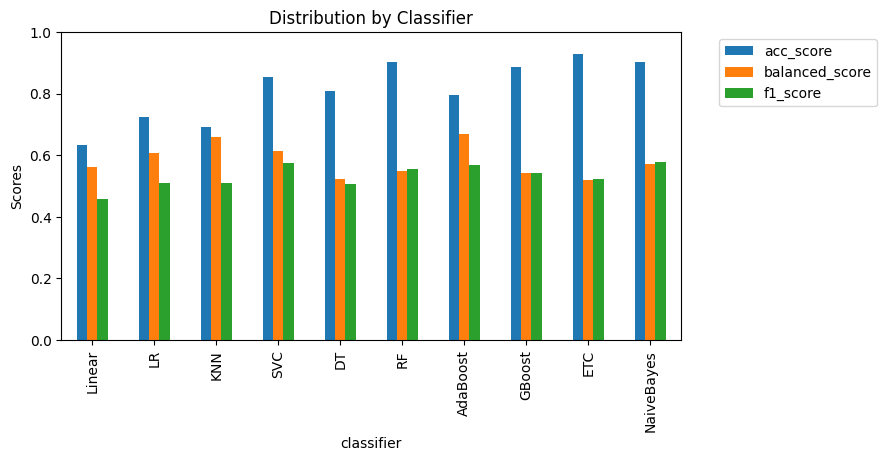

In [51]:
df_all.plot(kind='bar', ylim=(0., 1.0), figsize=(8,4), align='center')
plt.xticks(np.arange(len(clfs)), df_all.index)
plt.ylabel('Scores')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

## Building the Utility Function for Model Cross Validation

- balanced accuracy: the average of recall (also known as sensitivity or true positive rate) obtained on each class.

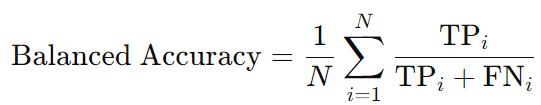

- where N is the number of classes, and TPi and FNi are the true positives and false negatives for class i.

#--------------------------------------------------------------